### Homework 2: Uncertainty and Vision
CS-229 Spring 2023

The goal of this assignment is to get familiar with training a computer vision task (Segmentation) with PyTorch, and to measure confidence calibration in your system. 

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models.segmentation import fcn_resnet50

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
class ToIntTensor(transforms.ToTensor):
    """A custom transform that replaces "ToTensor". ToTensor always converts to a 
    a float in range [0,1]. This one converts to an integer, which can represent
    our class labels per pixel in an image segmentation problem"""
    def __call__(self, pic):
        tensor = super().__call__(pic)
        tensor = (tensor * 255).to(torch.int64)
        return tensor
    
def get_voc_dataloader(batch_size=4):
    """
    Get the VOC 2007 segmentation dataset and return PyTorch
    dataloaders for both training and validation.
    """
    # Define image transforms for both the input image and the "label" image
    image_transforms = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])

    label_transforms = transforms.Compose([
        transforms.Resize((128, 128)),
        ToIntTensor()
    ])

    # This downloads the data automatically and creates a "dataset" object that applies the transforms
    data_dir = "~/cs299/hw2solution"  # Specify the path to save data
    train_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='train', download=True,
                                            transform=image_transforms, target_transform=label_transforms)
    val_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='val', download=True,
                                          transform=image_transforms, target_transform=label_transforms)

    # Create data loaders for the datasets
    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_dl, val_dl


In [3]:
def train_epoch(model, train_dl, val_dl, optimizer, device):
    """
    Train one epoch of model with optimizer, using data from train_dl.
    Do training on "device". 
    Return the train and validation loss and validation accuracy.
    """
    # We'll use the cross entropy loss. There's a nice feature that it
    # allows you to "ignore_index". In this case index 255 is the mask to ignore
    criterion = nn.CrossEntropyLoss(ignore_index=255)  # recommend to use in constructing loss

    # TODO: Train (3 points)
    # Iterate over the train dataloader
    # Put data batch on same device as model
    # "Forward pass" - run data through model, and use output to calculate loss. 
    # "backward pass"
    # Remember to keep track of training loss during loop.
    model.train()
    train_loss = 0.0
    for images, labels in train_dl:
        images = images.to(device)
        labels = labels.squeeze(1).to(device)

        optimizer.zero_grad()
        im_out = model(images)
        
        predictions = im_out['out']
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dl)

    # TODO: Validation loss and accuracy (2 points)
    # estimate the loss on the validation dataset
    # The network should be in "eval" mode (remember to go back to train mode for training)
    # Turn off grad tracking for speed 
    # Accuracy on validation datais very helpful to output - 
    # 69 percent of pixels are "background" - we hope to get better accuracy than that!
    model.eval()
    val_loss = 0.0
    correct_pixels = 0
    total_pixels = 0
    with torch.no_grad():
        for images, labels in val_dl:
            images = images.to(device)
            labels = labels.squeeze(1).to(device)

            im_out = model(images)
            predictions = im_out['out']
            loss = criterion(predictions, labels)
            val_loss += loss.item()

            _, predicted = torch.max(predictions, 1)
            valid_pixels = (labels != 255).sum().item()
            correct_pixels += (predicted == labels).sum().item()
            total_pixels += valid_pixels

    val_loss /= len(val_dl)
    accuracy = float(correct_pixels) / float(total_pixels) * 100.0

    return train_loss, val_loss, accuracy

### Main loop

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

# Define some hyperparameters
batch_size = 64  # Adjust batch size to make maximal use of GPU without running out of memory 
epochs = 50
learning_rate = 0.001
n_class = 21  # The class labels are 0...20. The label "255" is interpreted as a "mask" meant to be ignored

# Load model and data
model = fcn_resnet50(n_class=n_class).to(device)
train_dl, val_dl = get_voc_dataloader(batch_size=batch_size)

# Training loop
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.)

train_losses, val_losses = [], []
for epoch in range(epochs):
    train_loss, val_loss, accuracy = train_epoch(model, train_dl, val_dl, optimizer, device)
    
    # Print the loss, and store for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print('Epoch %d: Train loss: %.3f | Val loss: %.3f | Acc: %.3f' % (epoch+1, train_loss, val_loss, accuracy))

Using downloaded and verified file: C:\Users\jourd/cs299/hw2solution\VOCtrainval_06-Nov-2007.tar
Extracting C:\Users\jourd/cs299/hw2solution\VOCtrainval_06-Nov-2007.tar to C:\Users\jourd/cs299/hw2solution
Using downloaded and verified file: C:\Users\jourd/cs299/hw2solution\VOCtrainval_06-Nov-2007.tar
Extracting C:\Users\jourd/cs299/hw2solution\VOCtrainval_06-Nov-2007.tar to C:\Users\jourd/cs299/hw2solution
Epoch 1: Train loss: 2.906 | Val loss: 3.038 | Acc: 6.221
Epoch 2: Train loss: 2.323 | Val loss: 2.915 | Acc: 30.251
Epoch 3: Train loss: 1.606 | Val loss: 2.376 | Acc: 59.759
Epoch 4: Train loss: 1.173 | Val loss: 1.517 | Acc: 75.346
Epoch 5: Train loss: 0.962 | Val loss: 1.092 | Acc: 76.016
Epoch 6: Train loss: 0.856 | Val loss: 1.009 | Acc: 76.125
Epoch 7: Train loss: 0.795 | Val loss: 0.953 | Acc: 76.586
Epoch 8: Train loss: 0.704 | Val loss: 0.909 | Acc: 77.091
Epoch 9: Train loss: 0.688 | Val loss: 0.879 | Acc: 77.507
Epoch 10: Train loss: 0.629 | Val loss: 0.849 | Acc: 77.801


## Post training visualization and analysis

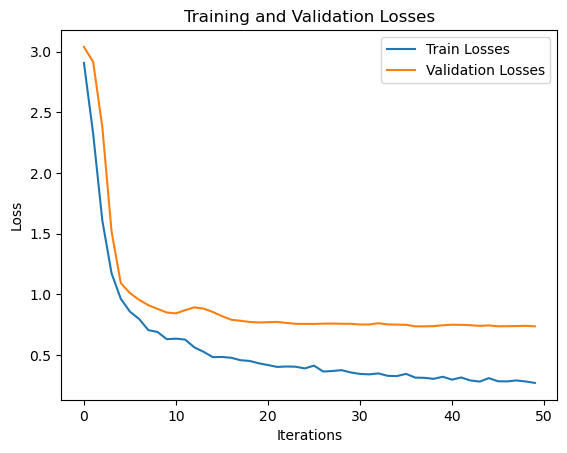

C:\Users\jourd\AppData\Local\Temp\ipykernel_19252\3547594222.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', n_class + 1)


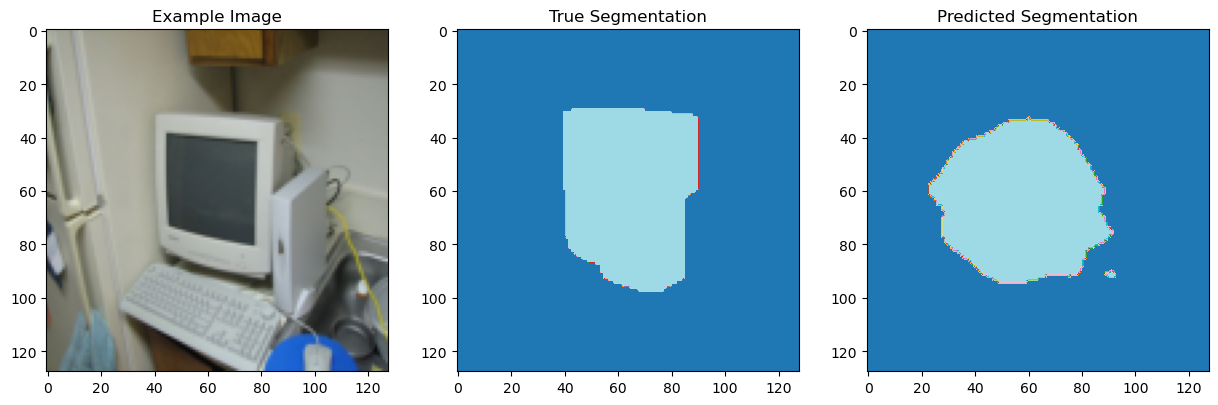

In [5]:
# TODO: Train and test loss plot
plt.plot(train_losses, label="Train Losses")
plt.plot(val_losses, label="Validation Losses")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.show()
# TODO: Print out an example image, true segmentation, and predicted segmentation
# 1 point
# Use a colormap to get good visualizations of the segmentation classes
# cmap = plt.cm.get_cmap('tab20', n_class + 1)  # tab20 is a colormap with 20 distinct colors
# cmap(numpy class array) outputs something with nice colors
plt.figure(figsize=(15,15))
with torch.no_grad():
    model.eval()
    ex_image, ex_true = next(iter(val_dl))
    ex_image = ex_image.to(device)
    ex_true = ex_true.to(device)
    ex_out = model(ex_image)
    _, ex_pred = torch.max(ex_out["out"], 1)

# Select a single image from the batch
ex_image = ex_image[0].cpu()
ex_true = ex_true[0].squeeze().cpu()
ex_pred = ex_pred[0].squeeze().cpu()

plt.subplot(1, 3, 1)
plt.imshow(ex_image.permute(1, 2, 0))
plt.title("Example Image")

plt.subplot(1, 3, 2)
cmap = plt.cm.get_cmap('tab20', n_class + 1)
plt.imshow(ex_true, cmap=cmap, vmin=0, vmax=n_class)
plt.title("True Segmentation")

plt.subplot(1, 3, 3)
plt.imshow(ex_pred, cmap=cmap, vmin=0, vmax=n_class)
plt.title("Predicted Segmentation")

plt.subplots_adjust(wspace=0.2)
plt.show()


In [6]:
# Feel free to use the outputs of my code for the confidence calibration plot and ECE
# Here I run the model on all points in the validation set. 
# I collect predictions on all pixels, excluding masks, and flatten them. 

model.eval()
with torch.no_grad():
    all_acc = []
    all_conf = []
    for i, (inputs, labels) in enumerate(val_dl):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)['out']
        labels = labels.squeeze(1).flatten(start_dim=1)  # batch, h, w  - integer values 0..20 or 255 for mask
        predicted_label = outputs.argmax(axis=1).flatten(start_dim=1)  # batch, h, w, integer 0...20  
        probs = outputs.softmax(axis=1)  # batch, n_class, h, w
        confidence = probs.max(axis=1).values.flatten(start_dim=1)  # Confidence in predicted label
        accuracy = (predicted_label == labels)
        accuracy_filter = accuracy[labels < 255]
        confidence_filter = confidence[labels < 255]
        all_acc.append(accuracy_filter)
        all_conf.append(confidence_filter)
        
all_acc = torch.cat(all_acc).cpu().numpy()  # accuracy to predict pixel class across all pixels and images, excluding masks
all_conf = torch.cat(all_conf).cpu().numpy()  # confidence of prediction for each pixel and image, excluding masks
        
# Get the average confidence and accuracy for points within different confidence ranges
bins = 10
bin_boundaries = np.linspace(0, 1, bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]
bin_centers = 0.5*(bin_lowers+bin_uppers)
bin_acc = np.zeros(bins)  # Store accuracy within each bin
bin_conf = np.zeros(bins)  # Store confidence within each bin
bin_frac = np.zeros(bins)  # Store the fraction of data in included in each bin
for i in range(bins):
    in_bin = np.logical_and(all_conf >= bin_lowers[i], all_conf < bin_uppers[i])
    bin_frac[i] = np.sum(in_bin) / len(all_conf)  # fraction of points in bin
    if bin_frac[i] > 0.:
        bin_acc[i] = all_acc[in_bin].mean()  # average accuracy in this bin
        bin_conf[i] = all_conf[in_bin].mean()  # average confidence in this bin
    else:
        bin_acc[i], bin_conf[i] = 0, 0  # If no points are in this bin, they don't contribute to ECE anyway

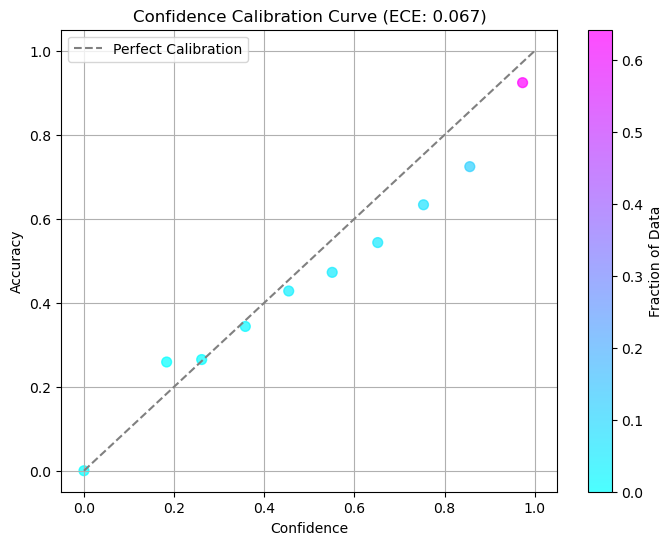

ECE:  0.06650192996119426


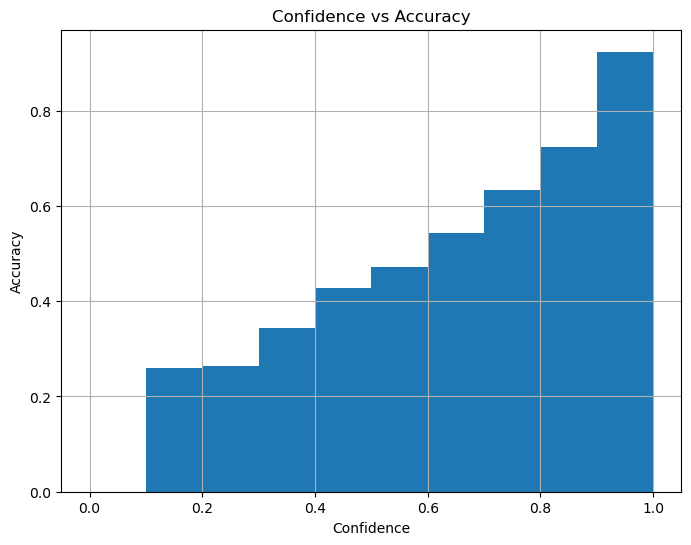

In [7]:
# TODO: Plot confidence calibration curve and calculate expected calibration error (1 point), using 
ece = 0.0
for conf, acc, frac in zip(bin_conf, bin_acc, bin_frac):
    ece += abs(conf - acc) * frac

# Plot the confidence calibration curve
plt.figure(figsize=(8, 6))
scatter = plt.scatter(bin_conf, bin_acc, s=50, c=bin_frac, cmap='cool', alpha=0.7)
plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Calibration')
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Confidence Calibration Curve (ECE: {:.3f})'.format(ece))
colorbar = plt.colorbar(scatter, label='Fraction of Data')
plt.legend()
plt.grid(True)
plt.show()
print("ECE: ", ece)

# TODO: confidence versus accuracy bar chart
plt.figure(figsize=(8, 6))
plt.bar(bin_centers, bin_acc, width=0.1, align='center')
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Confidence vs Accuracy')
plt.grid(True)
plt.show()

In [8]:
torch.cuda.empty_cache()

In [ ]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
device = t.device('mps') if t.backends.mps.is_available() else device